In [7]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat

sys.path.append("../")


from baselines.fno import  FNO2d, FNO_train



torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)



downsample_ratio = 1
n_train = 1000
n_test = 200
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


###################################
# load data
###################################
data_path = "../data/airfoil/"
coordx = np.load(data_path+"NACA_Cylinder_X.npy")
coordy = np.load(data_path+"NACA_Cylinder_Y.npy")
data_in = np.stack((coordx, coordy), axis=3)
data_out = np.load(data_path+"NACA_Cylinder_Q.npy")[:,4,:,:] #density, velocity 2d, pressure, mach number

_, nx, ny, _ = data_in.shape

data_in_ds = data_in[:, 0::downsample_ratio, 0::downsample_ratio, :]
data_out_ds = data_out[:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis]

L=1.0
grid_x, grid_y = np.meshgrid(np.linspace(0, L, nx), np.linspace(0, L, ny))
grid_x, grid_y = grid_x.T, grid_y.T
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
# x_train, y_train are [n_data, n_x, n_channel] arrays

print(data_in_ds[0:n_train,:,:,:].shape, np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis].shape)
# x_train = torch.from_numpy(data_in_ds[0:n_train, :, :, :].astype(np.float32))
x_train = torch.from_numpy(
    np.concatenate(
        (data_in_ds[0:n_train,:,:,:], 
         np.tile(grid_x_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_train, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)

y_train = torch.from_numpy(data_out_ds[0:n_train, :, :, :].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
# x_test = torch.from_numpy(data_in_ds[-n_test:, :, :, :].astype(np.float32))
x_test = torch.from_numpy(
    np.concatenate(
        (data_in_ds[-n_test:,:,:,:], 
         np.tile(grid_x_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
         np.tile(grid_y_ds, (n_test, 1, 1))[:,:,:, np.newaxis],
        ),
        axis=3,
    ).astype(np.float32)
)




y_test = torch.from_numpy(data_out_ds[-n_test:, :, :, :].astype(np.float32))

print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)

from models import UnitGaussianNormalizer
x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])

(1000, 221, 51, 2) (1000, 221, 51, 1)
x_train.shape:  torch.Size([1000, 221, 51, 4])
y_train.shape:  torch.Size([1000, 221, 51, 1])


In [8]:
print(coordx.shape,coordy.shape,data_in.shape,data_out.shape)

(2490, 221, 51) (2490, 221, 51) (2490, 221, 51, 2) (2490, 221, 51)


C:\Users\15461\AppData\Local\Temp\ipykernel_23532\885552118.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


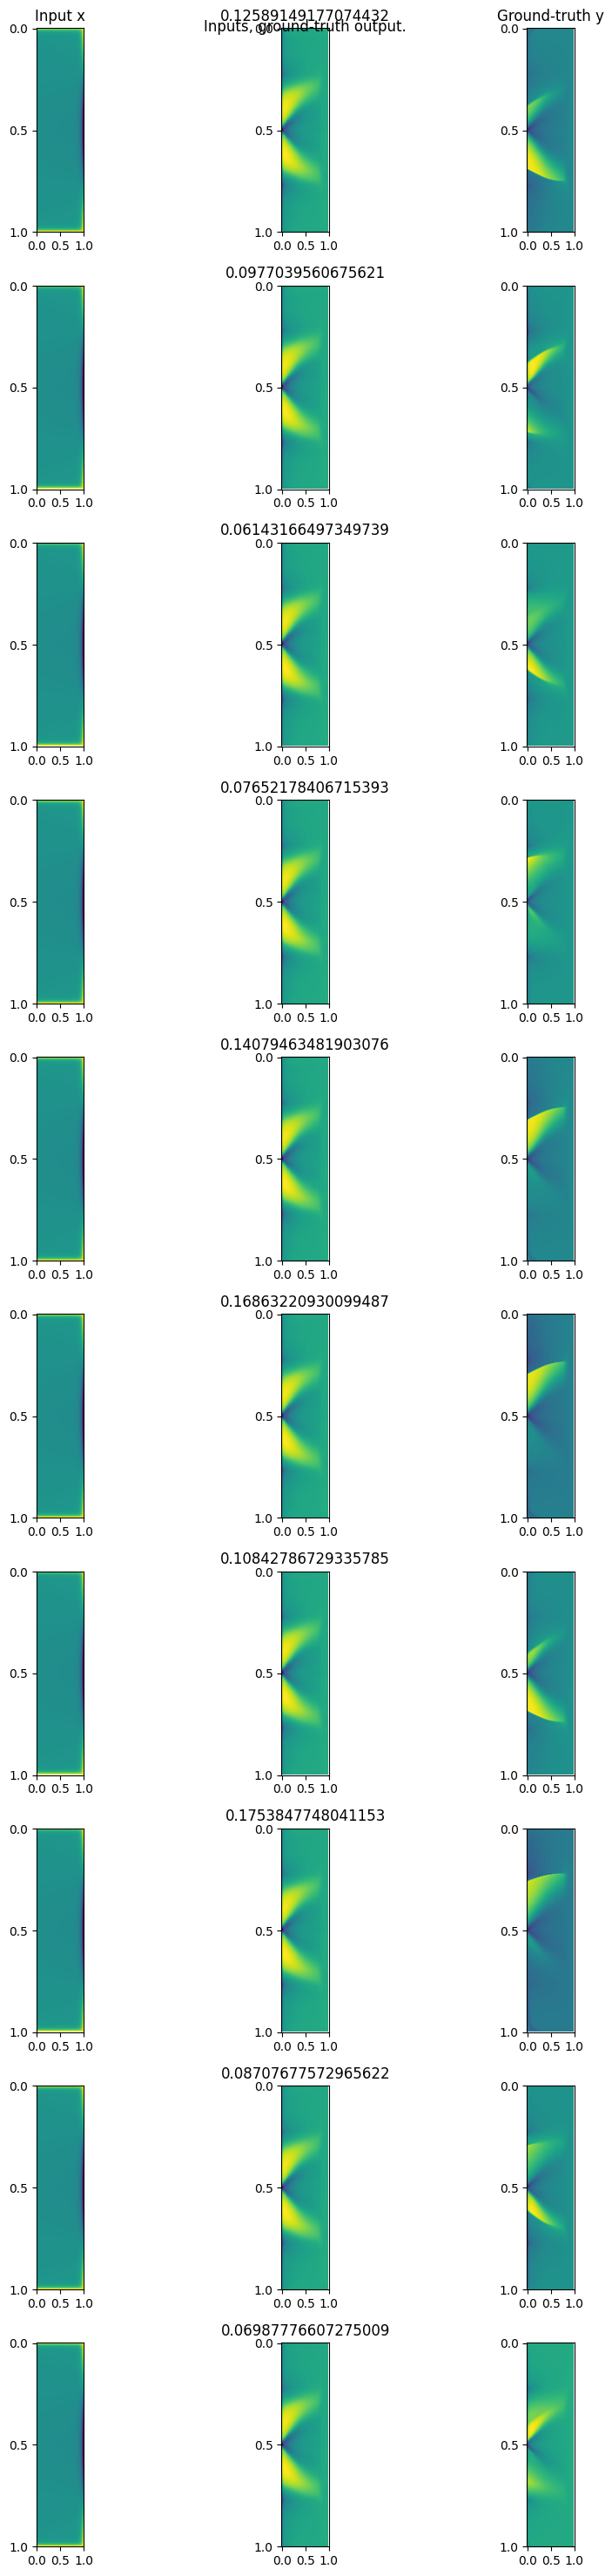

In [55]:
import matplotlib.pyplot as plt
from models.losses import LpLoss
# h = 1/Np
n=10
model = torch.load('FNO_naca_model').to('cuda')
fig = plt.figure(figsize=(10,3*n))
myloss = LpLoss(d=1, p=2, size_average=False)
with torch.no_grad():
    for index in range(n):
        x = x_test[index]
        x = x_normalizer.encode(x)
        y = y_test[index]
        # print(x.shape,y.shape)  #torch.Size([221, 51, 4]) torch.Size([221, 51, 1])


        ax = fig.add_subplot(n, 3, index*3 + 1)
        x = x.to('cpu')
        im = ax.imshow(x[:,:,0])

        if index == 0: 
            ax.set_title('Input x')
        plt.xticks(np.linspace(0, 51, 3), np.linspace(0, 1, 3))
        plt.yticks(np.linspace(0, 221, 3), np.linspace(0, 1, 3))

        x = x.to('cuda')
        out = model(x.unsqueeze(0)).to('cpu')
        # print(out.shape)#torch.Size([1, 221, 51, 1])
        ax = fig.add_subplot(n, 3, index*3 + 2)
        im = ax.imshow(out[0,:,:,0])
        out = y_normalizer.decode(out)
        loss = myloss(out.reshape(1,-1), y.reshape(1,-1)).item()


        ax.set_title(loss)
        plt.xticks(np.linspace(0, 51, 3), np.linspace(0, 1, 3))
        plt.yticks(np.linspace(0, 221, 3), np.linspace(0, 1, 3))


        ax = fig.add_subplot(n, 3, index*3 + 3)
        ax.imshow(y[:,:,0])
        if index == 0: 
            ax.set_title('Ground-truth y')
        plt.xticks(np.linspace(0, 51, 3), np.linspace(0, 1, 3))
        plt.yticks(np.linspace(0, 221, 3), np.linspace(0, 1, 3))




fig.suptitle('Inputs, ground-truth output.', y=0.98)
plt.tight_layout()
fig.show()

C:\Users\15461\AppData\Local\Temp\ipykernel_23532\2345620127.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


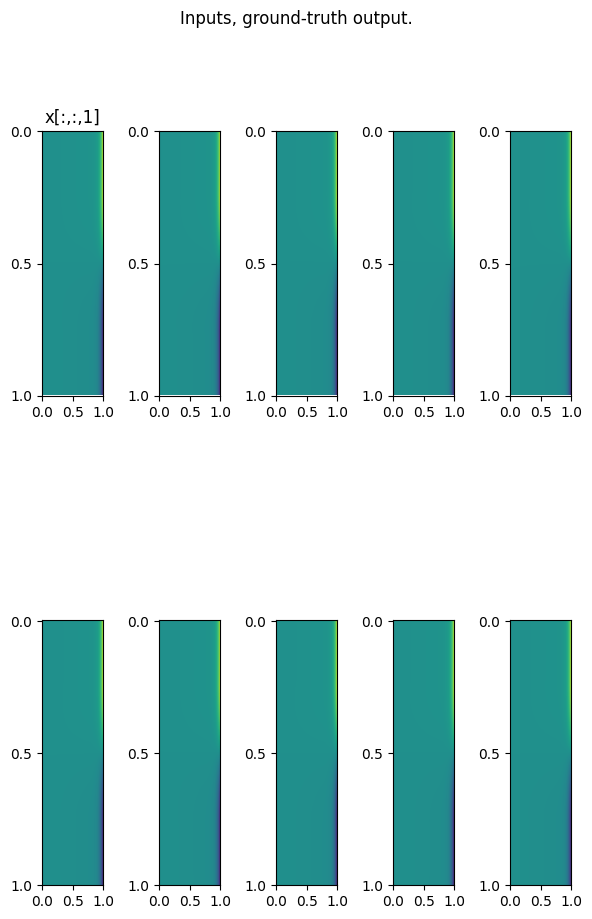

In [54]:
import matplotlib.pyplot as plt

# h = 1/Np
n=10

fig = plt.figure(figsize=(6,2*n))

with torch.no_grad():
    for index in range(n):
        x = x_test[index]
        x_1 = x_test[index+1]
        x = x_normalizer.encode(x)
        x_1 = x_normalizer.encode(x_1)


        y = y_test[index]
        # print(x.shape,y.shape)  #torch.Size([221, 51, 4]) torch.Size([221, 51, 1])


        ax = fig.add_subplot(4, 5, index+1)
        im = ax.imshow(x[:,:,1])
        if index == 0: 
            ax.set_title('x[:,:,1]')
        plt.xticks(np.linspace(0, 51, 3), np.linspace(0, 1, 3))
        plt.yticks(np.linspace(0, 221, 3), np.linspace(0, 1, 3))

        # ax = fig.add_subplot(4, 5, index*2+2)
        # im = ax.imshow(x[:,:,1]-x_1[:,:,1])
        # if index == 0: 
        #     ax.set_title('x[:,:,1]')
        # plt.xticks(np.linspace(0, 51, 3), np.linspace(0, 1, 3))
        # plt.yticks(np.linspace(0, 221, 3), np.linspace(0, 1, 3))

        
        # ax = fig.add_subplot(n, 2, index*2 + 2)
        # im = ax.imshow(x[:,:,1])
        # if index == 0: 
        #     ax.set_title('x[:,:,1]')
        # plt.xticks(np.linspace(0, 51, 3), np.linspace(0, 1, 3))
        # plt.yticks(np.linspace(0, 221, 3), np.linspace(0, 1, 3))



fig.suptitle('Inputs, ground-truth output.', y=0.98)
plt.tight_layout()
fig.show()